# Q2: Lets go deeper! CaffeNet for PASCAL classification (20 pts)

**Note:** You are encouraged to reuse code from the previous task. Finish Q1 if you haven't already!


As you might have seen, the performance of the SimpleCNN model was pretty low for PASCAL. This is expected as PASCAL is much more complex than FASHION MNIST, and we need a much beefier model to handle it.

In this task we will be constructing a variant of the [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) architecture, known as CaffeNet. If you are familiar with Caffe, a prototxt of the network is available [here](https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/train_val.prototxt). A visualization of the network is available [here](http://ethereon.github.io/netscope/#/preset/caffenet).


## 2.1 Build CaffeNet (5 pts)
Here is the exact model we want to build. In this task, `torchvision.models.xxx()` is NOT allowed. Define your own CaffeNet! We use the following operator notation for the architecture:
1. Convolution: A convolution with kernel size $k$, stride $s$, output channels $n$, padding $p$ is represented as $conv(k, s, n, p)$.
2. Max Pooling: A max pool operation with kernel size $k$, stride $s$ as $maxpool(k, s)$.
3. Fully connected: For $n$ output units, $FC(n)$.
4. ReLU: For rectified linear non-linearity $relu()$

```
ARCHITECTURE:
-> image
-> conv(11, 4, 96, ’VALID’)
-> relu()
-> max_pool(3, 2)
-> conv(5, 1, 256, 'SAME')
-> relu()
-> max_pool(3, 2)
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 256, ’SAME’)
-> relu()
-> max_pool(3, 2)
-> flatten()
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(20)
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar 
!tar -xf VOCtest_06-Nov-2007.tar

--2022-03-01 20:38:28--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M   230MB/s    in 1.9s    

2022-03-01 20:38:30 (230 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2022-03-01 20:38:32--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================>

In [3]:
%cd drive/MyDrive/spring22/16824/hw1

/content/drive/MyDrive/spring22/16824/hw1


In [4]:
%load_ext autoreload
%autoreload 2

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset


class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, inp_size=224, c_dim=3):
        super().__init__()
        
        self.conv1 = nn.Conv2d(c_dim, 96, 11, stride=4, padding='valid')
        self.pool1 = nn.MaxPool2d(3, stride=2)

        self.conv2 = nn.Conv2d(96, 256, 5, padding='same')
        self.pool2 = nn.MaxPool2d(3, stride=2)

        self.conv3 = nn.Conv2d(256, 384, 3, padding='same')
        self.conv4 = nn.Conv2d(384, 384, 3, padding='same')
        self.conv5 = nn.Conv2d(384, 256, 3, padding='same')
        self.pool5 = nn.MaxPool2d(3, stride=2)

        init_kernel = lambda x: int(math.floor((x - 11) / 4.) + 1.)
        kernel_post_pool = lambda x: int(math.floor((x - 3) / 2.) + 1)
        kernel_post_all_pool = lambda x: kernel_post_pool(
            kernel_post_pool(kernel_post_pool(x)))
        final_conv_dim = kernel_post_all_pool(init_kernel(inp_size))

        # print(init_kernel(inp_size))
        # print(kernel_post_all_pool(init_kernel(inp_size)))

        self.flat_dim = final_conv_dim * final_conv_dim * 256

        self.fc1 = nn.Linear(self.flat_dim, 4096)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(4096, 20)

        self.__init_weights__()
    
    def forward(self, x):
        
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = F.relu(self.conv4(F.relu(self.conv3(out))))
        out = self.pool5(F.relu(self.conv5(out)))

        out = out.view(out.size(0), self.flat_dim)
        out = self.dropout1(F.relu(self.fc1(out)))
        out = self.dropout2(F.relu(self.fc2(out)))

        out = self.fc3(out)

        return out
    
    def __init_weights__(self):
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.conv4.weight)
        nn.init.xavier_uniform_(self.conv5.weight)

## 2.2 Save the Model (5 pts)
Fill out `save_model()` in `trainer.py` to save the checkpoints of the model periodically. **You will need these models later.**


## 2.3 Train and Test (5pts)
Show clear screenshots of testing MAP and training loss for 50 epochs. The final MAP should be at least around 0.4. Please evaluate your model to calculate the MAP on the testing dataset every 250 iterations. Use the following hyperparamters:
* batch_size=32
* Adam optimizer with lr=0.0001

**NOTE: SAVE AT LEAST 5 EVENLY SPACED CHECKPOINTS DURING TRAINING (1 at end)**

In [ ]:
args = ARGS(epochs=75,
            batch_size=32,
            lr=0.0001,
            use_cuda=True,
            step_size=30,
            save_freq=20,
            save_at_end=True,
            val_every=250)
model_name = 'CaffeNet15'
model = CaffeNet()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler, model_name=model_name)
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.692487
Test MAP: 0.06637844196524341
Train Epoch: 0 [100 (64%)]	Loss: 0.270360
Train Epoch: 1 [200 (27%)]	Loss: 0.237356
Test MAP: 0.1034286589043297
Train Epoch: 1 [300 (91%)]	Loss: 0.255687
Train Epoch: 2 [400 (55%)]	Loss: 0.255883
Train Epoch: 3 [500 (18%)]	Loss: 0.266582
Test MAP: 0.14738560280964594
Train Epoch: 3 [600 (82%)]	Loss: 0.243261
Train Epoch: 4 [700 (46%)]	Loss: 0.240831
Test MAP: 0.15910551786223245
Train Epoch: 5 [800 (10%)]	Loss: 0.232303
Train Epoch: 5 [900 (73%)]	Loss: 0.208665
Train Epoch: 6 [1000 (37%)]	Loss: 0.234164
Test MAP: 0.16992096241099244
Train Epoch: 7 [1100 (1%)]	Loss: 0.243265
Train Epoch: 7 [1200 (64%)]	Loss: 0.226628
Test MAP: 0.1997322805218893
Train Epoch: 8 [1300 (28%)]	Loss: 0.217647
Train Epoch: 8 [1400 (92%)]	Loss: 0.212018
Train Epoch: 9 [1500 (55%)]	Loss: 0.215826
Test MAP: 0.21384292326776322
Train Epoch: 10 [1600 (19%)]	Loss: 0.204236
Train Epoch: 10 [1700 (83%)]	Loss: 0.199365
Test MAP: 0.23107708808103258


**INSERT YOUR TENSORBOARD SCREENSHOTS HERE**

**Screenshots - Loss**

![image](images/caffenet-loss.png)

**Screenshots - Learning Rate**

![image](images/caffenet-lr.png)

**Screenshots - mAP**

![image](images/caffenet-map.png)

## 2.4 Visualizing: Conv-1 filters (5pts)
Extract and compare the weights of conv1 filters at different stages of the training (at least from 5 different epochs).

- Write a function to load your model checkpoints.
- Get the weights for conv1 from the loaded model.
- Visualize the weights using the following vis() function.

Sometimes the filters all look very random and may not change too much across epochs. Don't worry! You will get full credits as long as the code is correct.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# This function plots all the filters in one image. 
def vis(conv1):
    assert type(conv1) == np.ndarray
    assert conv1.shape == (11, 11, 3, 96)
    im = np.zeros((120, 120, 3))
    step_size = 12
    column = 0
    row = 0
    for k in range(conv1.shape[3]):
        this_filter = conv1[:, :, :, k]
        im[column*step_size:column*step_size+11, row*step_size:row*step_size+11, :] = this_filter
        column = column + 1
        if column == 10:
            column = 0
            row = row + 1
    image = Image.fromarray(np.uint8((im-np.mean(im))/np.std(im)))

    return image

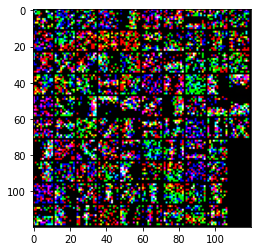

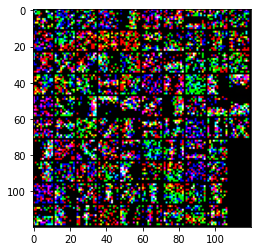

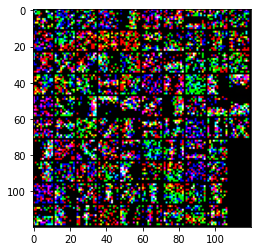

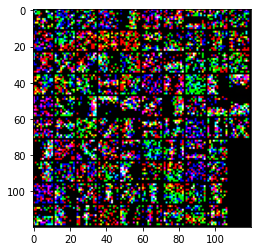

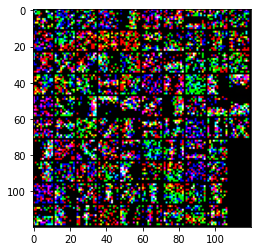

In [8]:
# Write your code here to get the conv1 filters for each epoch
def get_conv1_filters(model, model_name, epochs):
    conv1s = []

    for epoch in epochs:
        filename = 'models/checkpoint-{}-epoch{}.pth'.format(model_name, epoch)
        model.load_state_dict(torch.load(filename))
        conv1s.append(list(model.parameters())[0].cpu().detach().numpy())

    return conv1s

model = CaffeNet()
model_name = 'CaffeNet15'
epochs = [0, 20, 40, 60, 75]
conv1s = get_conv1_filters(model, model_name, epochs)

for conv1 in conv1s:
  conv1 = np.transpose(conv1, axes=(2, 3, 1, 0))
  # For each epoch, use vis() to visualize the filters.
  # Before passing the weights into vis(),
  # make sure it is an numpy array with shape (11, 11, 3, 96).
  # You may need torch.permute to reorganize the dimensions.
  
  img = vis(conv1)
  plt.imshow(img)
  plt.show()